In [1]:
import time
import sys

from graph_nets import blocks
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
from matplotlib import pyplot as plt
from simulate_orbits import *
import numpy as np
from copy import deepcopy

import random

import graph_nets as gn
import sonnet as snt
import tensorflow as tf
import networkx as nx

# For debugging only
#tf.compat.v1.enable_eager_execution()

In [2]:
def get_orbital_velocity(radius, mass_planet, mass_star, G, noise = 0):
    """Calculate the velocity required to keep an orbit

    Parameters
    ---------- 
    radius : float
      the radial distance from the body to the center of the orbit
    mass_planet : float
      mass of the planet orbiting
    mass_star : float
      mass of the body at the center of the orbit
    G : float 
      Gravitational Constant
    noise: float
      The maximum fractional amount by which the initial velocity is perturbed. 
      Defaults to zero

    Returns
    ---------- 
    velocity : float
      the orbital velocity

    """

    velocity = np.sqrt(G*mass_star/radius)

    # Add noise
    if noise > 0:
        delta_vel = rand.uniform(*(-noise,noise), size = np.shape(velocity))
        velocity *= (1.+delta_vel)

    return np.array(velocity)

def get_trajectory(planets, num_time_steps):
    '''
    Calculate real trajectory using Euler integration
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    num_time_steps : float
        The number of integration steps    
      
    Returns
    -------
    x_traj, p_traj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    '''
    
    nplanets = len(planets)
    x_traj = np.zeros([num_time_steps, nplanets, 2])
    p_traj = np.zeros([num_time_steps, nplanets, 2])
    for i in range(num_time_steps):
        pos = []
        mom = []
        for planet in planets:
            pos.append(planet.orbit[i][0:2])
            mom.append(planet.orbit[i][3:5]*planet.mass)
        
        x_traj[i] = np.array(pos)*AU #km
        p_traj[i] = np.array(mom)*AU/YEAR #km/s

    return x_traj, p_traj

In [3]:
def get_input_graph(planets, xtraj, t, noise_level = 0.05):
    '''
    Convert a given time into a GraphNets graph that can be used to train a model
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    xtraj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    t: int
        The time at which the trajectory is evaluated
    noise_level: float
        Fractional noise added to the training, defaults to 0.05
        
    Returns
    -------
    graph_dict: dict
        A dictionary containing globals, edges, nodes, senders and receivers
    '''
    nplanets = len(planets)
    nodes, edges, senders, receivers = [], [], [], []
    for i in range(nplanets):
        noise_mass = np.random.normal(0, noise_level)
        mass = planets[i].mass#*(1+noise_mass)
        nodes.append([mass/mercury.mass]) #Use Mercury's mass for units to normalize
        for j in range(nplanets):
            # I do this instead of if i != j, so the distances and forces are not duplicate, this
            # improves the model. I am basically telling the model that F(ij)=F(ji)
            if i > j:
                d = xtraj[t,j,:] - xtraj[t,i,:]
                if noise_level > 0:
                    noise_dist = tf.random.normal([2], 0, noise_level, tf.float32) 
                    edges.append(d*(1+noise_dist))
                else:
                    edges.append(d)
 
                receivers.append(i)
                senders.append(j)
    
    return{
      "globals": [G],
      "nodes": nodes,
      "edges": edges, 
      "receivers": receivers, 
      "senders": senders 
    }  

## Integration Functions

In [4]:
def get_distances(x0, nplanets, as_tensor = True):
    '''
    Convert positions to distances
    '''
    dx = []
    for i in range(nplanets):
        for j in range(nplanets):
            if i > j:
                dx.append(x0[j] - x0[i])
    
    if as_tensor == True:
        dx = tf.convert_to_tensor(dx, dtype=np.float32)
    else:
        dx = np.array(dx)
        
    return dx

def model_gn(dx, num_processing_steps):
    '''
    Use the model to go from dx to dp
    '''
    graph = input_graph_test.replace(edges=dx)
    outputs = model(graph, num_processing_steps)
    outputs_p = get_momentum_update(outputs)
    output = sum(outputs_p)/num_processing_steps
    dp = output*np.std(dp_traj_np)

    edges = [output.edges for output in outputs]
    forces_unnorm = sum(edges)/num_processing_steps
    forces = forces_unnorm*np.std(dp_traj_np)
    return dp, forces

def get_leapfrog_step(x, ph, dt, planets, model, num_processing_steps):   #(x, ph, dt, m1, m2, model):
    '''
    Perform a step for the leapfrog integration
    '''
    dtm = []
    for planet in planets:
        dtm.append([dt/planet.mass])
    
    deltax=ph*tf.convert_to_tensor(dtm,dtype = np.float32)
    
    x1 = x+deltax

    dx = get_distances(x, len(planets))

    dp, force = model(dx, num_processing_steps)
    ph3 = ph + dp

    return x1, ph3, dp, force


def leapfrog_integration(x0, p0, planets,dt, num_steps, model, num_processing_steps):
    '''
    Learn the orbit through leapfrom integration
    '''
    def body(i, x0, p0, x_pred, dp_pred, f_pred):
        x, ph, dp, force =  get_leapfrog_step(x0, p0, dt, planets,model, num_processing_steps)
        return i+1, x, ph, x_pred.write(i, x), dp_pred.write(i-1, dp/np.std(dp_traj_np)), f_pred.write(i-1, force)
    
    # Distance
    dx = get_distances(x0, len(planets))

    # Model predict*norm_p = F*dt
    # (ph = phalf)
    dph, fh = model(dx,  num_processing_steps)
    ph = p0 + 0.5*dph
    x = tf.identity(x0)
    
    i = 0

    x_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps, element_shape=x0.shape)
    dp_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=x0.shape)
    f_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=fh.shape)

    x_pred = x_pred.write(0, x0)
    
    _, _, _, x_pred, dp_pred, f_pred = tf.while_loop(
    lambda i, *unused_args: i < num_steps,
        body,
        loop_vars = [1, x0, ph, x_pred, dp_pred, f_pred]
    )
    return x_pred.stack(), dp_pred.stack(), f_pred.stack()

In [5]:
def generate_batch(planets, total_time, delta_time, batch_size, norm_factor = 1):
    num_time_steps = int(total_time/delta_time)
    x_traj_ls = []
    dp_traj_ls = []
    for i in range(batch_size):
        planets_batch = deepcopy(planets)
        for planet in planets_batch:
            if planet.name is not 'Sun':
                pos_planet = np.linalg.norm(planet.pos)
                vel_planet = get_orbital_velocity(pos_planet, planet.mass, planets_batch[0].mass, G)
                planet.initiate(pos_planet, vel_planet)
        
        simulate(planets_batch, total_time, delta_time)
        x_traj_np, p_traj_np = get_trajectory(planets_batch, int(total_time/delta_time))
        dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]
        
        x_traj_ls.append(x_traj_np)
        dp_traj_ls.append(dp_traj_np/norm_factor)

    x_traj = tf.convert_to_tensor(np.asarray(x_traj_ls), dtype=np.float32)
    dp_traj = tf.convert_to_tensor(np.asarray(dp_traj_ls), dtype=np.float32)
        
        
    return x_traj, dp_traj


In [143]:
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = 0.1*DAY#/YEAR

total_time_test = 5000*delta_time
num_time_steps_test = int(total_time_test/delta_time)

total_time_tr = 200*delta_time
num_time_steps_tr = int(total_time_tr/delta_time)


num_processing_steps_tr = 2
patience = 20
batch_size = 500
#d_patience = 1e-5
d_patience = 0
noise_level = 0.05

# How much time between logging and printing the current results.
log_every_iterations = 1000
num_training_iterations = 500000

sun = Body()
sun.name = 'Sun'
sun.mass = 1.98892 * 10**30 # kg
sun.pos = np.zeros(3) # m

mercury = Body()
mercury.name = 'Mercury'
mercury.mass = 0.33011 * 10**24 #kg
pos_mercury = 0.387*AU
vel_mercury = get_orbital_velocity(pos_mercury, mercury.mass, sun.mass, G)
mercury.initiate(pos_mercury, vel_mercury)
    
venus = Body()
venus.name = 'Venus'
venus.mass = 4.8685 * 10**24 #kg
pos_venus = 0.723*AU
vel_venus = get_orbital_velocity(pos_venus, venus.mass, sun.mass, G)
venus.initiate(pos_venus, vel_venus)
    
earth = Body()
earth.name = 'Earth'
earth.mass = 5.9742 * 10**24 #kg
pos_earth = 1*AU
vel_earth = get_orbital_velocity(pos_earth, earth.mass, sun.mass, G)
earth.initiate(pos_earth, vel_earth)


sun.vel = -(np.array(mercury.vel)*mercury.mass + 
            np.array(venus.vel)*venus.mass +
            np.array(earth.vel)*earth.mass
            )/sun.mass

# Center at zero (improves stability)
sun.pos = -(np.array(mercury.pos)*mercury.mass + 
            np.array(venus.pos)*venus.mass +
            np.array(earth.pos)*earth.mass
            )/sun.mass
#sun.pos = np.zeros(3)

planets = [sun, mercury, venus, earth]
nplanets = len(planets)
    
planets_gn = deepcopy(planets)

simulate(planets, total_time_test, delta_time)

x_traj_np, p_traj_np = get_trajectory(planets, num_time_steps_test)
dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]

dp_traj_norm = tf.convert_to_tensor(
    dp_traj_np/np.std(dp_traj_np), dtype=np.float32)

x_traj_test = tf.convert_to_tensor(x_traj_np, dtype=np.float32)
p_traj_test = tf.convert_to_tensor(p_traj_np, dtype=np.float32)

input_dict_test = get_input_graph(planets, x_traj_test, 0, noise_level = 0)

input_graph_test = utils_tf.data_dicts_to_graphs_tuple([input_dict_test])

In [150]:
cm = np.zeros(3)
for planet in planets:
    cm += planet.mass*planet.vel
    
cm

array([1.26892577e+22, 1.94485704e+22, 0.00000000e+00])

In [147]:
sun.pos

array([144127.48554943, 204316.0428212 ,      0.        ])

In [7]:
x_traj_tr, dp_traj_tr = generate_batch(planets_gn, total_time_tr, delta_time, batch_size, norm_factor = np.std(dp_traj_np))

In [8]:
'''
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = 0.1*DAY#/YEAR
total_time = 5000*delta_time
num_time_steps = int(total_time/delta_time)
nplanets = 1
num_processing_steps_tr = 1
patience = 10
d_patience = 1e-4
noise_level = 0.0

# How much time between logging and printing the current results.
log_every_iterations = 10000
num_training_iterations = 1000000

# Mercury with random initial conditions
for i in range(nplanets):
    # Sun
    sun = Body()
    sun.name = 'Sun'
    sun.mass = 1.98892 * 10**30 # kg
    sun.pos = np.zeros(3) # m

    mercury = Body()
    mercury.name = 'Mercury'
    mercury.mass = 0.33011 * 10**24 #kg
    pos_mercury = 0.387*AU
    vel_mercury = get_orbital_velocity(pos_mercury, mercury.mass, sun.mass, G)
    mercury.initiate(pos_mercury, vel_mercury)
    
    venus = Body()
    venus.name = 'Venus'
    venus.mass = 4.8685 * 10**24 #kg
    pos_venus = 0.723*AU
    vel_venus = get_orbital_velocity(pos_venus, venus.mass, sun.mass, G)
    venus.initiate(pos_venus, vel_venus)
    
    earth = Body()
    earth.name = 'Earth'
    earth.mass = 5.9742 * 10**24 #kg
    pos_earth = 1*AU
    vel_earth = get_orbital_velocity(pos_earth, earth.mass, sun.mass, G)
    earth.initiate(pos_earth, vel_earth)


    #sun.vel = np.zeros(3)
    sun.vel = -(np.array(mercury.vel)*mercury.mass + 
                np.array(venus.vel)*venus.mass #+
                #np.array(earth.vel)*earth.mass
               )/sun.mass
    #sun.vel = -np.array(mercury.vel)*mercury.mass/sun.mass
    # Center at zero (improves stability)
    sun.pos = -(np.array(mercury.pos)*mercury.mass + 
                np.array(venus.pos)*venus.mass #+
                #np.array(earth.pos)*earth.mass
               )/sun.mass
    
    planets = [sun, mercury, venus]
    #planets = [sun, mercury]
    
    sun_gn = deepcopy(sun)
    mercury_gn = deepcopy(mercury)
    venus_gn = deepcopy(venus)
    earth_gn = deepcopy(earth)
    planets_gn = [sun_gn, mercury_gn, venus_gn]
    #planets_gn = [sun_gn, mercury_gn]

    simulate(planets, total_time, delta_time)
    
x_traj_np, p_traj_np = get_trajectory(planets, num_time_steps)
#x_noise = np.random.normal(0, 0.05, x_traj_np.shape)
#x_traj_np_noisy = x_traj_np*(1+x_noise) 
dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]
#dp_traj_norm = tf.convert_to_tensor(
#    dp_traj_np/np.std(dp_traj_np, axis=(0,2), keepdims=True), dtype=np.float32)

dp_traj_norm = tf.convert_to_tensor(
    dp_traj_np/np.std(dp_traj_np), dtype=np.float32)

x_traj = tf.convert_to_tensor(x_traj_np, dtype=np.float32)
#x_traj_noisy = tf.convert_to_tensor(x_traj_np_noisy, dtype=np.float32)
p_traj = tf.convert_to_tensor(p_traj_np, dtype=np.float32)
'''

"\n# Global constants\nDAY = 24*3600. # Day in seconds\nYEAR = 365.25*DAY #Year\ndelta_time = 0.1*DAY#/YEAR\ntotal_time = 5000*delta_time\nnum_time_steps = int(total_time/delta_time)\nnplanets = 1\nnum_processing_steps_tr = 1\npatience = 10\nd_patience = 1e-4\nnoise_level = 0.0\n\n# How much time between logging and printing the current results.\nlog_every_iterations = 10000\nnum_training_iterations = 1000000\n\n# Mercury with random initial conditions\nfor i in range(nplanets):\n    # Sun\n    sun = Body()\n    sun.name = 'Sun'\n    sun.mass = 1.98892 * 10**30 # kg\n    sun.pos = np.zeros(3) # m\n\n    mercury = Body()\n    mercury.name = 'Mercury'\n    mercury.mass = 0.33011 * 10**24 #kg\n    pos_mercury = 0.387*AU\n    vel_mercury = get_orbital_velocity(pos_mercury, mercury.mass, sun.mass, G)\n    mercury.initiate(pos_mercury, vel_mercury)\n    \n    venus = Body()\n    venus.name = 'Venus'\n    venus.mass = 4.8685 * 10**24 #kg\n    pos_venus = 0.723*AU\n    vel_venus = get_orbital_

Text(0.5, 1.0, 'Graph')

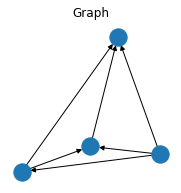

In [9]:
# Generate and visualize a Graph

data_dict = get_input_graph(planets, x_traj_test,0)
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)

ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graphs_nx[0], ax=ax)
ax.set_title("Graph")

In [10]:
graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict])

In [11]:
# Get sum over all received nodes for each body

reducer = tf.unsorted_segment_sum
t1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(graphs_tuple)
t2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(graphs_tuple)

#with tf.Session() as sess:
#    print(t.eval())

#print(t1)
#print(t2)
#print(t1-t2)

In [12]:
# Create the model.
model = models.EncodeProcessDecode(node_output_size=0, edge_output_size=2, global_output_size=0)

In [13]:
def get_momentum_update(output_ops):
    reducer = tf.unsorted_segment_sum
    
    dp = []
    for output_op in output_ops:
        b1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        b2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(output_op)
        dp.append(b1-b2)
    '''
    dp = [
        blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        for output_op in output_ops]
    '''
    return dp


def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.
    """
    loss_ops = [
        tf.reduce_mean(
            tf.reduce_sum((output_op - target_op)**2, axis=-1))
        for output_op in output_ops
    ]
    return loss_ops

In [14]:
t = tf.random_uniform([], minval=0, maxval=num_time_steps_tr - 1, dtype=tf.int32)
input_dict_tr = []
for i in range(batch_size):
    input_dict_tr.append(get_input_graph(planets, x_traj_tr[i], t, noise_level = noise_level))

input_graph_tr = utils_tf.data_dicts_to_graphs_tuple(input_dict_tr)
output_model = model(input_graph_tr, num_processing_steps_tr)
output_ops_tr = get_momentum_update(output_model)
target_nodes_tr = tf.reshape(dp_traj_tr[:,t], shape=[batch_size*nplanets, 2])



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# Integration (test)
nsteps_int = num_time_steps_test
x0 = x_traj_test[0]
p0 = p_traj_test[0]
xp, pp, fp = leapfrog_integration(
    x0, p0, planets_gn, delta_time, nsteps_int, model_gn, num_processing_steps_tr)
loss_test = tf.reduce_mean(
    tf.reduce_sum(
    (pp - dp_traj_norm[:nsteps_int-1])**2., axis = -1
    ))

In [16]:
# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

In [17]:
# Optimizer.
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

In [18]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

nsteps_no_improvement = 0
last_iteration = 0
previous_loss = 0
iterations = []
losses_tr = []
losses_test = []

In [19]:
start_time = time.time()
last_log_time = start_time

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), ")
      
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "outputs": output_ops_tr
    })
    the_time = time.time()
    
    if train_values["loss"] >= (previous_loss - d_patience): 
        nsteps_no_improvement += 1
    else: 
        nsteps_no_improvement = 0
    
    previous_loss = train_values["loss"]
        
    if nsteps_no_improvement >= patience: 
        print('Convergence achieved')
        print('Iterations = ', iteration)
        print('Time = ', time.time() - start_time, 'seconds.')
        print('Training 1-step loss = ', train_values["loss"])
        break
    
    if iteration%log_every_iterations == 0:
        test_orbit = sess.run({
            "x_pred": xp, 
            "f_pred": fp, 
            "loss": loss_test
        })
        last_log_time = the_time
        elapsed = time.time() - start_time
        iterations.append(iteration)
        losses_tr.append(train_values["loss"])
        losses_test.append(test_orbit["loss"])
        print(
            "# {:07d}, T {:.1f}, Ltr {:.8f}, Ltest {:.8f}".format(
                iteration, elapsed, train_values["loss"], test_orbit["loss"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), 
# 0000000, T 33.8, Ltr 7.47054768, Ltest 5.36187410
# 0001000, T 81.1, Ltr 1.52736843, Ltest 2.27879524
# 0002000, T 128.3, Ltr 0.79484224, Ltest 2.91336370
# 0003000, T 175.6, Ltr 0.63281435, Ltest 2.95888019
# 0004000, T 223.5, Ltr 0.54773819, Ltest 2.17172861
# 0005000, T 271.0, Ltr 0.48447043, Ltest 2.42423773
# 0006000, T 318.0, Ltr 0.41839910, Ltest 2.52416110
# 0007000, T 365.9, Ltr 0.35642952, Ltest 2.06037140
# 0008000, T 414.2, Ltr 0.30891290, Ltest 1.72702861
# 0009000, T 461.5, Ltr 0.28066921, Ltest 1.51651990
# 0010000, T 509.9, Ltr 0.26031223, Ltest 1.35793018
# 0011000, T 557.0, Ltr 0.22956310, Ltest 0.97076738
# 0012000, T 603.0, Ltr 0.19021416, Ltest 1.00911987
# 0013000, T 648.9, Ltr 0.15061788, Ltest 1.14294577
# 0014000, T 694.6, Ltr 0.12233683, Ltest 1.19203067
# 0015000, T 739.8, Ltr 0.10749145, Ltest 1.10413527
# 0016000, T 785.0, Ltr 0.08540917, Ltest 1.26436913
# 0017000, T 830.4, Ltr 0.075

# 0151000, T 7060.0, Ltr 0.00311073, Ltest 0.00415619
# 0152000, T 7103.9, Ltr 0.00310612, Ltest 0.00444376
# 0153000, T 7148.2, Ltr 0.00296292, Ltest 0.00453227
# 0154000, T 7192.5, Ltr 0.00298506, Ltest 0.00641191
# 0155000, T 7236.5, Ltr 0.00285555, Ltest 0.00567561
# 0156000, T 7280.5, Ltr 0.00296038, Ltest 0.00687633
# 0157000, T 7324.4, Ltr 0.00294337, Ltest 0.00553291
# 0158000, T 7368.4, Ltr 0.00293291, Ltest 0.00526943
# 0159000, T 7412.3, Ltr 0.00303048, Ltest 0.00423348
# 0160000, T 7456.6, Ltr 0.00305000, Ltest 0.00619015
# 0161000, T 7500.3, Ltr 0.00281312, Ltest 0.00489096
# 0162000, T 7544.0, Ltr 0.00291608, Ltest 0.00412483
# 0163000, T 7587.7, Ltr 0.00271856, Ltest 0.00448554
# 0164000, T 7631.4, Ltr 0.00264045, Ltest 0.00577466
# 0165000, T 7675.2, Ltr 0.00307929, Ltest 0.00550725
# 0166000, T 7719.1, Ltr 0.00304256, Ltest 0.00556022
# 0167000, T 7763.1, Ltr 0.00289814, Ltest 0.00629141
# 0168000, T 7806.7, Ltr 0.00276255, Ltest 0.00521738
# 0169000, T 7850.2, Ltr 0.0

# 0302000, T 13747.2, Ltr 0.00197232, Ltest 0.01029206
# 0303000, T 13792.3, Ltr 0.00166644, Ltest 0.01092691
# 0304000, T 13837.3, Ltr 0.00192927, Ltest 0.00843787
# 0305000, T 13882.1, Ltr 0.00189689, Ltest 0.00708000
# 0306000, T 13926.8, Ltr 0.00178288, Ltest 0.00944264
# 0307000, T 13971.6, Ltr 0.00198275, Ltest 0.01131629
# 0308000, T 14016.2, Ltr 0.00184818, Ltest 0.00850010
# 0309000, T 14060.8, Ltr 0.00192315, Ltest 0.00775985
# 0310000, T 14105.4, Ltr 0.00190013, Ltest 0.00961508
# 0311000, T 14150.1, Ltr 0.00187524, Ltest 0.00989534
# 0312000, T 14194.5, Ltr 0.00205609, Ltest 0.01456197
# 0313000, T 14238.8, Ltr 0.00179574, Ltest 0.01064136
# 0314000, T 14283.3, Ltr 0.00184068, Ltest 0.01106983
# 0315000, T 14327.7, Ltr 0.00192158, Ltest 0.01400248
# 0316000, T 14372.3, Ltr 0.00191153, Ltest 0.00837573
# 0317000, T 14416.8, Ltr 0.00181832, Ltest 0.01211545
# 0318000, T 14461.1, Ltr 0.00185120, Ltest 0.01182478
# 0319000, T 14505.5, Ltr 0.00178332, Ltest 0.00678242
# 0320000,

# 0451000, T 20541.0, Ltr 0.00156753, Ltest 0.01035386
# 0452000, T 20587.0, Ltr 0.00163942, Ltest 0.01070712
# 0453000, T 20634.1, Ltr 0.00169991, Ltest 0.01192808
# 0454000, T 20680.4, Ltr 0.00176093, Ltest 0.01353467
# 0455000, T 20726.0, Ltr 0.00165464, Ltest 0.01461531
# 0456000, T 20772.7, Ltr 0.00171214, Ltest 0.00960722
# 0457000, T 20818.1, Ltr 0.00158475, Ltest 0.01115132
# 0458000, T 20864.4, Ltr 0.00168024, Ltest 0.01078947
# 0459000, T 20910.1, Ltr 0.00162974, Ltest 0.01702647
# 0460000, T 20956.6, Ltr 0.00158287, Ltest 0.00872178
# 0461000, T 21005.1, Ltr 0.00154561, Ltest 0.01864361
# 0462000, T 21051.8, Ltr 0.00158231, Ltest 0.01273396
# 0463000, T 21098.3, Ltr 0.00178264, Ltest 0.01165920
# 0464000, T 21143.9, Ltr 0.00158020, Ltest 0.01006371
# 0465000, T 21189.3, Ltr 0.00175726, Ltest 0.01524908
# 0466000, T 21235.5, Ltr 0.00183849, Ltest 0.01558814
# 0467000, T 21282.3, Ltr 0.00173935, Ltest 0.00927740
# 0468000, T 21329.7, Ltr 0.00166573, Ltest 0.01204799
# 0469000,

## Plots

Text(0, 0.5, 'Test loss')

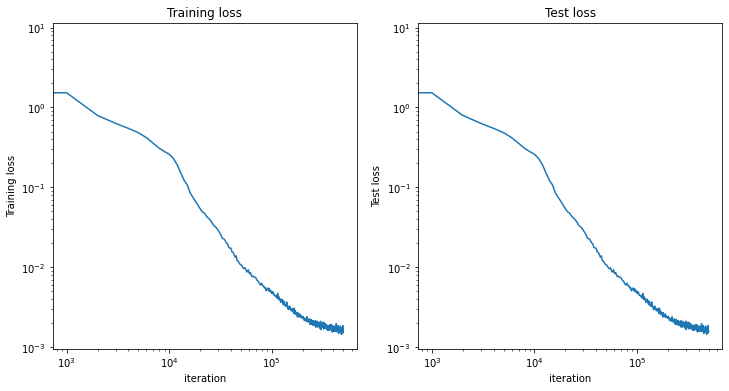

In [20]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

ax = axs[0]
ax.plot(iterations,losses_tr)
ax.set_title('Training loss')
ax.set_xlabel('iteration')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Training loss')

ax = axs[1]
ax.set_title('Test loss')
ax.plot(iterations,losses_tr)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('Test loss')

In [21]:
# Get prediction as numpy array
x_pred = test_orbit["x_pred"]
#p_pred = test_orbit["p_pred"]
f_pred = test_orbit["f_pred"]

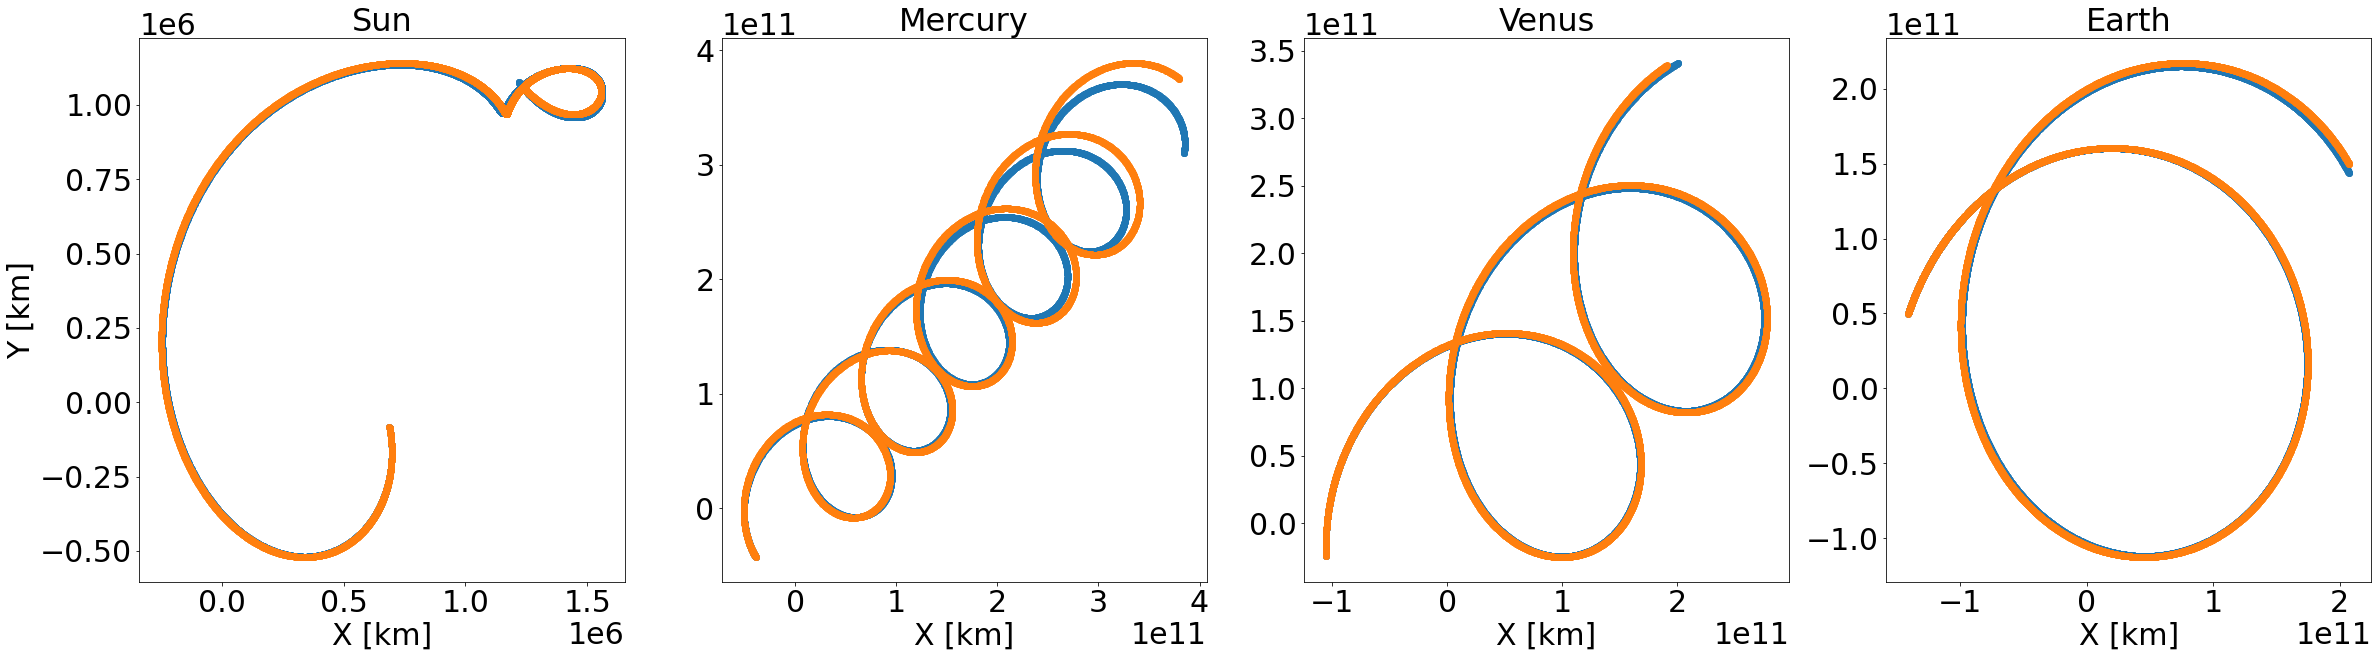

In [101]:
nsteps_plot = 5000
plt.rcParams.update({'font.size': 30})
fig, axs =plt.subplots(nrows = 1, ncols = len(planets), figsize = (10*len(planets), 10))

periods = np.array([225, 88, 225, 1000])
factor = 10*periods

axs[0].set_ylabel('Y [km]')
for i in range(len(planets)):
    ax = axs[i]
    
    shift = x_traj_np[:,i,0].max()/factor[i]*np.arange(nsteps_plot)

    ax.set_title(planets[i].name, fontsize = 32)
    ax.scatter(x_traj_np[:nsteps_plot,i,0]+shift, x_traj_np[:nsteps_plot,i,1]+shift, label='Truth')
    ax.scatter(x_pred[:nsteps_plot,i,0]+shift, x_pred[:nsteps_plot,i,1]+shift, label='Prediction')
    ax.set_xlabel('X [km]')
    
    
plt.savefig('/Users/Pablo/Desktop/orbits')

In [78]:
nplanets = len(planets_gn)
nforce = len(f_pred[0])
order = [[0,1], [0,2], [1,2], [0,3], [1,3], [2,3]]
#order = [[0,1], [0,2], [1,2]]

masses_arr = np.zeros([nplanets, 1])
for i in range(nplanets):
    masses_arr[i] = planets_gn[i].mass

nsteps_table = 1000

table = np.zeros([nsteps_table*len(f_pred[0]), 7])
it = 0
for i in range(nsteps_table):
    x = x_pred[i]
    dx = get_distances(x, nplanets, as_tensor=False)
    for j in range(nforce):
        ind = order[j]
        #print([planets[ind[0]].mass, planets[ind[1]].mass], dx[j], np.linalg.norm(dx[j]), f_pred[i, j])
        table[it] = np.concatenate([[planets[ind[0]].mass, planets[ind[1]].mass], dx[j], [np.linalg.norm(dx[j])], f_pred[i, j]/delta_time])
        it+=1
    #table[i] =  np.concatenate([masses_arr, dx, f_pred[i]], axis = 1)

In [97]:
np.savetxt('/Users/Pablo/Desktop/orbits.txt', table)

In [55]:
input_graph_tr.senders.eval(session=sess)[:6]

array([0, 0, 1, 0, 1, 2], dtype=int32)

In [56]:
input_graph_tr.receivers.eval(session=sess)[:6]

array([1, 2, 2, 3, 3, 3], dtype=int32)

In [98]:
nplanets = len(planets_gn)
nforce = len(f_pred[0])
order = [[0,1], [0,2], [1,2], [0,3], [1,3], [2,3]]
#order = [[0,1], [0,2], [1,2]]

masses_arr = np.zeros([nplanets, 1])
for i in range(nplanets):
    masses_arr[i] = planets_gn[i].mass

nsteps_table = 2000

table = np.zeros([int(nsteps_table*len(f_pred[0])/2), 7])
it = 0
for i in range(nsteps_table):
    x = x_pred[i]
    dx = get_distances(x, nplanets, as_tensor=False)
    for j in range(nforce):
        if j in [0,1,3]: #Keep only interactions between sun and planets
            #All in units of solar mass, AU, year
            ind = order[j]
            table[it] = np.concatenate([[
                planets[ind[0]].mass/sun.mass, planets[ind[1]].mass/sun.mass], 
                dx[j]/AU, 
                [np.linalg.norm(dx[j])/AU], 
                f_pred[i, j]/delta_time/sun.mass/AU*YEAR**2])
            it+=1


In [95]:
table

array([[ 1.00000000e+00,  1.65974499e-07,  2.62208879e-01, ...,
         3.86992845e-01,  1.59668107e-05,  8.77478742e-05],
       [ 1.00000000e+00,  2.44781087e-06,  7.04284728e-01, ...,
         7.23001552e-01,  1.77053516e-04,  7.50178833e-06],
       [ 1.00000000e+00,  3.00374072e-06,  9.42635298e-01, ...,
         1.00000303e+00,  1.28276035e-04, -6.07779402e-05],
       ...,
       [ 1.00000000e+00,  1.65974499e-07,  3.86083513e-01, ...,
         3.86158888e-01,  2.96415674e-05,  5.40877700e-05],
       [ 1.00000000e+00,  2.44781087e-06, -6.10738337e-01, ...,
         7.28711256e-01, -1.57709772e-04, -1.35466064e-04],
       [ 1.00000000e+00,  3.00374072e-06, -4.72168654e-01, ...,
         1.00183692e+00, -3.79190496e-05, -1.26746105e-04]])

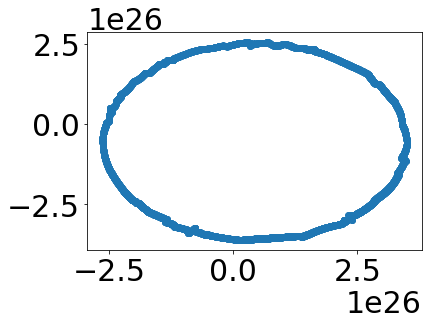

In [58]:
plt.scatter(f_pred[:,3,0], f_pred[:,3,1], marker= 'o')

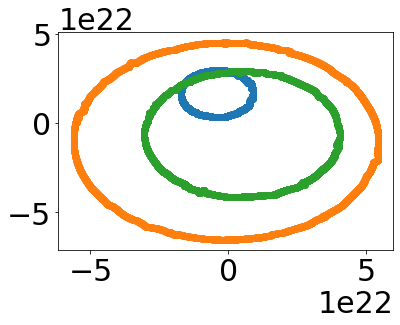

In [75]:
plt.scatter(f_pred[:,0,0]/delta_time, f_pred[:,0,1]/delta_time, marker= 'o')
plt.scatter(f_pred[:,1,0]/delta_time, f_pred[:,1,1]/delta_time, marker= 'o')
plt.scatter(f_pred[:,3,0]/delta_time, f_pred[:,3,1]/delta_time, marker= 'o')

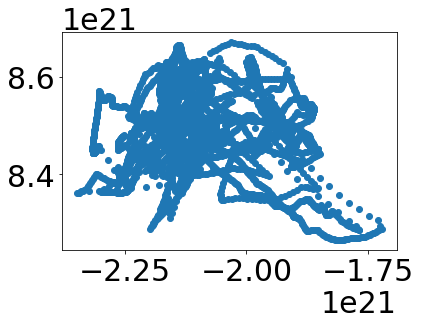

In [77]:
plt.scatter(f_pred[:,2,0]/delta_time, f_pred[:,2,1]/delta_time, marker= 'o')

In [104]:
d_0 = x_traj_np[:,0,:] - x_traj_np[:,1,:]
ftrue_0 = G*sun.mass*mercury.mass*d_0/np.linalg.norm(d_0,axis =1, keepdims=True)**3.

d_1 = x_traj_np[:,0,:] - x_traj_np[:,2,:]
ftrue_1 = G*sun.mass*venus.mass*d_1/np.linalg.norm(d_1,axis =1, keepdims=True)**3.

d_2 = x_traj_np[:,0,:] - x_traj_np[:,3,:]
ftrue_2 = G*sun.mass*earth.mass*d_2/np.linalg.norm(d_2,axis =1, keepdims=True)**3.

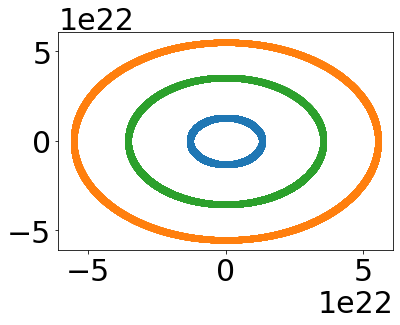

In [105]:
plt.scatter(ftrue_0[:,0], ftrue_0[:,1])
plt.scatter(ftrue_1[:,0], ftrue_1[:,1])
plt.scatter(ftrue_2[:,0], ftrue_2[:,1])

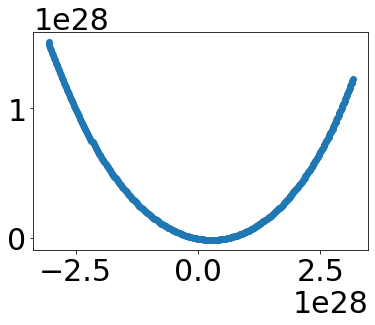

In [129]:
plt.scatter(p_traj_np[900:1200,0,0], p_traj_np[900:1200,0,1])

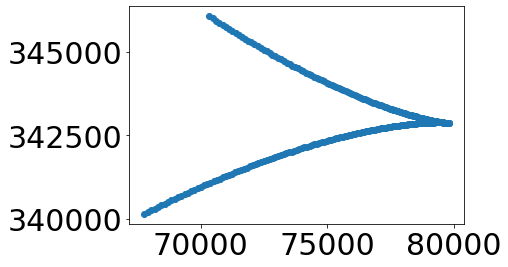

In [128]:
plt.scatter(x_traj_np[900:1200,0,0], x_traj_np[900:1200,0,1])

In [35]:
dx[0].tol

AttributeError: 'numpy.ndarray' object has no attribute 'tol'

In [131]:
x_traj_np[900:1200,0,0]

array([67762.04397459, 67898.78457952, 68034.92595983, 68170.46439004,
       68305.39614934, 68439.71752175, 68573.42479631, 68706.51426721,
       68838.98223402, 68970.82500185, 69102.03888147, 69232.62018957,
       69362.56524887, 69491.87038832, 69620.53194328, 69748.54625568,
       69875.90967422, 70002.61855452, 70128.66925931, 70254.05815861,
       70378.78162989, 70502.83605829, 70626.21783674, 70748.92336617,
       70870.9490557 , 70992.2913228 , 71112.94659345, 71232.91130236,
       71352.18189313, 71470.75481842, 71588.62654015, 71705.79352964,
       71822.25226786, 71937.99924551, 72053.03096332, 72167.34393212,
       72280.93467308, 72393.79971787, 72505.93560888, 72617.33889931,
       72728.00615346, 72837.93394682, 72947.11886632, 73055.55751046,
       73163.2464895 , 73270.18242568, 73376.36195334, 73481.78171914,
       73586.43838224, 73690.32861448, 73793.44910051, 73895.79653807,
       73997.36763806, 74098.15912482, 74198.16773622, 74297.39022391,
      

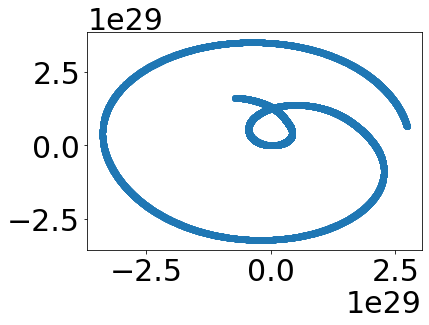

In [132]:
plt.scatter(p_traj_np[:,0,0], p_traj_np[:,0,1])

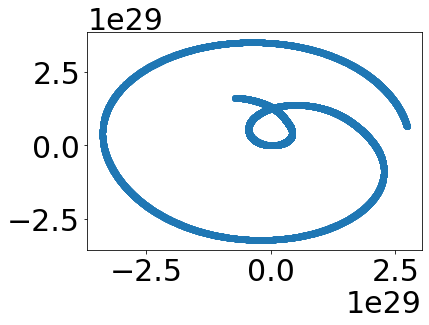

In [137]:
plt.scatter(p_traj_np[:,0,0], p_traj_np[:,0,1])